# Integrable Circuit Spectrum, Analysis

In [2]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from kraus_channels import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
path = "../../../data/"

def resample_diluted(diluted_channel, U = None, num_samples = None):
    d = diluted_channel.d
    c = diluted_channel.c
    rank = diluted_channel.rank
    
    n = int(np.log2(d))
    spectrum_resample_list = []
    for i in tqdm(range(num_samples)):
            
        diluted_resample = DilutedKrausMap(U=U, c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, use_coords=True, keep_real=False)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

## Nairobi 4 Qubit Integrable

In [9]:
model1 = loader(path + "nairobi_4qubit_integrable_shallow.model")
d = model1.channel.d

np.random.seed(42)
random.seed(42)

circuit = integrable_circuit(4, 2)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.85, kraus_part=KrausMap(d, rank=2))

In [10]:
print(circuit)

     ┌──────────────┐┌────────────┐┌─────────────┐┌─────────────┐»
q_0: ┤ Rz(-0.78829) ├┤0           ├┤ Rz(-2.1613) ├┤ Rz(0.63532) ├»
     └┬────────────┬┘│  iswap^0.5 │├─────────────┤└┬────────────┤»
q_1: ─┤ Rz(2.8319) ├─┤1           ├┤ Rz(-2.1615) ├─┤0           ├»
      ├────────────┤ ├────────────┤├─────────────┤ │  iswap^0.5 │»
q_2: ─┤ Rz(1.4577) ├─┤0           ├┤ Rz(-2.7766) ├─┤1           ├»
     ┌┴────────────┤ │  iswap^0.5 │└┬────────────┤ ├────────────┤»
q_3: ┤ Rz(0.61989) ├─┤1           ├─┤ Rz(2.3008) ├─┤ Rz(2.9525) ├»
     └─────────────┘ └────────────┘ └────────────┘ └────────────┘»
«                    ┌────────────┐ ┌────────────┐              
«q_0: ───────────────┤0           ├─┤ Rz(2.0888) ├──────────────
«      ┌────────────┐│  iswap^0.5 │┌┴────────────┤┌────────────┐
«q_1: ─┤ Rz(1.3074) ├┤1           ├┤ Rz(-1.8074) ├┤0           ├
«     ┌┴────────────┤├────────────┤├─────────────┤│  iswap^0.5 │
«q_2: ┤ Rz(-3.0123) ├┤0           ├┤ Rz(-1.9992) ├┤1           ├
«     └

In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample1 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_12316\647190484.py:16: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x00000205FD614F70> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


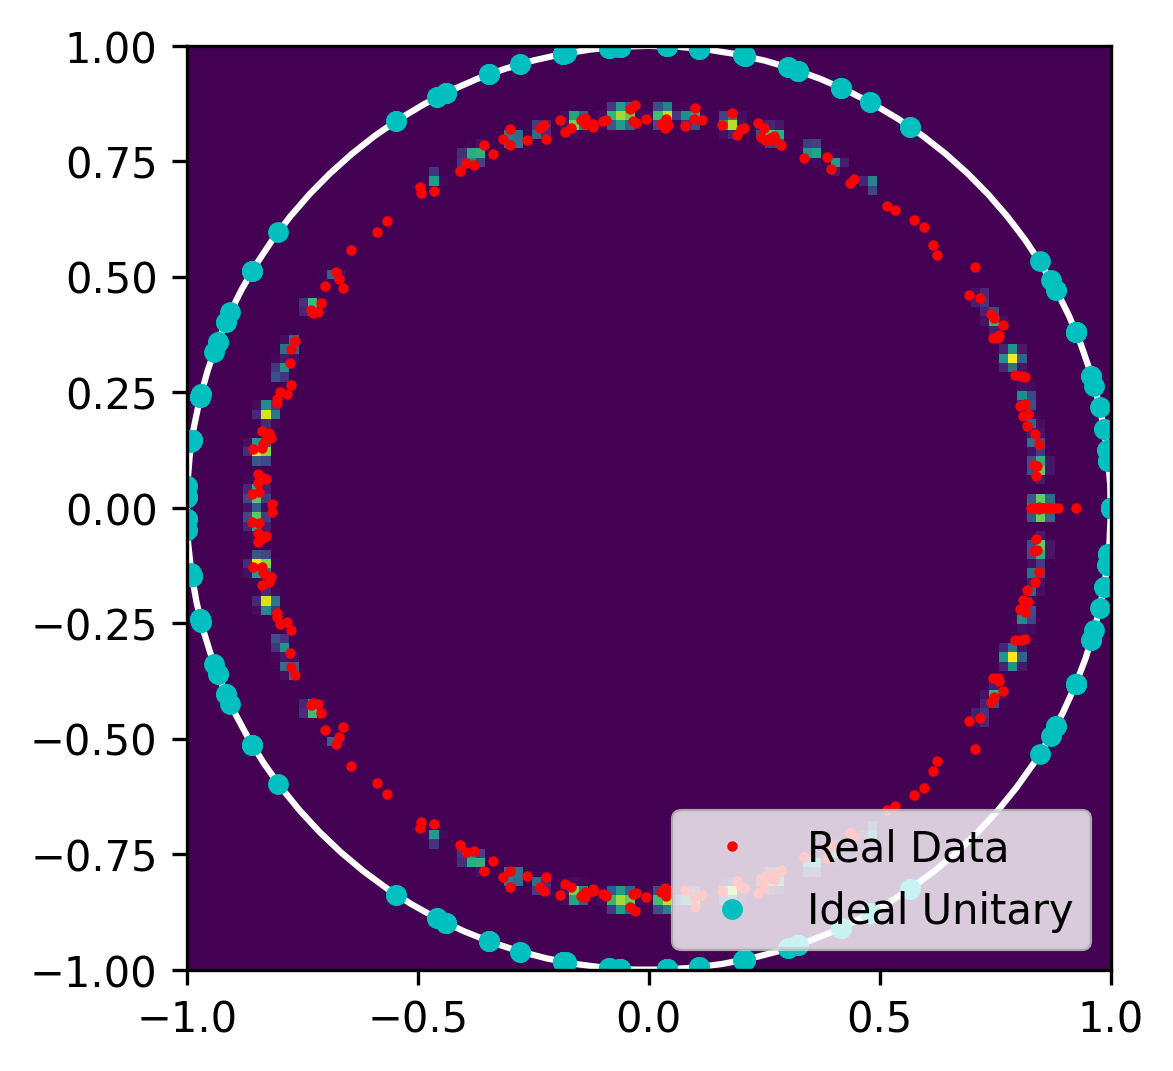

In [13]:
spectrum_model1 = channel_spectrum(model1.channel, use_coords=True)
spectrum_unitary1 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h, bins, _, _ = plt.hist2d(spectrum_resample1[:,0], spectrum_resample1[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "ro", markersize=1.5)
plt.plot(spectrum_unitary1[:,0], spectrum_unitary1[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("integrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

## Nairobi 4 Qubit Non-Integrable

In [14]:
model2 = loader(path + "nairobi_4qubit_nonintegrable_shallow.model")
d = model2.channel.d

np.random.seed(42)
random.seed(42)

circuit = nonintegrable_circuit(4, 2)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.75, kraus_part=KrausMap(d, rank=4))

In [15]:
print(circuit)

     ┌─────────────┐┌────────────┐   ┌───────┐    ┌─────────────┐          »
q_0: ┤ R(π/2,-π/4) ├┤0           ├───┤ y^0.5 ├────┤ R(π/2,-π/4) ├──────────»
     └──┬────────┬─┘│  iswap^0.5 │┌──┴───────┴───┐└┬────────────┤┌────────┐»
q_1: ───┤ y^-0.5 ├──┤1           ├┤ R(-π/2,-π/4) ├─┤0           ├┤ x^-0.5 ├»
      ┌─┴────────┴─┐├────────────┤└┬────────────┬┘ │  iswap^0.5 │├───────┬┘»
q_2: ─┤ R(π/2,π/4) ├┤0           ├─┤ R(π/2,π/4) ├──┤1           ├┤ y^0.5 ├─»
     ┌┴────────────┤│  iswap^0.5 │ ├────────────┤ ┌┴────────────┤└───────┘ »
q_3: ┤ R(π/2,-π/4) ├┤1           ├─┤ R(π/2,π/4) ├─┤ R(π/2,-π/4) ├──────────»
     └─────────────┘└────────────┘ └────────────┘ └─────────────┘          »
«     ┌────────────┐   ┌───────┐                  
«q_0: ┤0           ├───┤ y^0.5 ├──────────────────
«     │  iswap^0.5 │   ├───────┤    ┌────────────┐
«q_1: ┤1           ├───┤ y^0.5 ├────┤0           ├
«     ├────────────┤┌──┴───────┴───┐│  iswap^0.5 │
«q_2: ┤0           ├┤ R(-π/2,-π/4) ├┤1           ├
«

In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample2 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_12316\352788526.py:16: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x00000205FDB7ACB0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


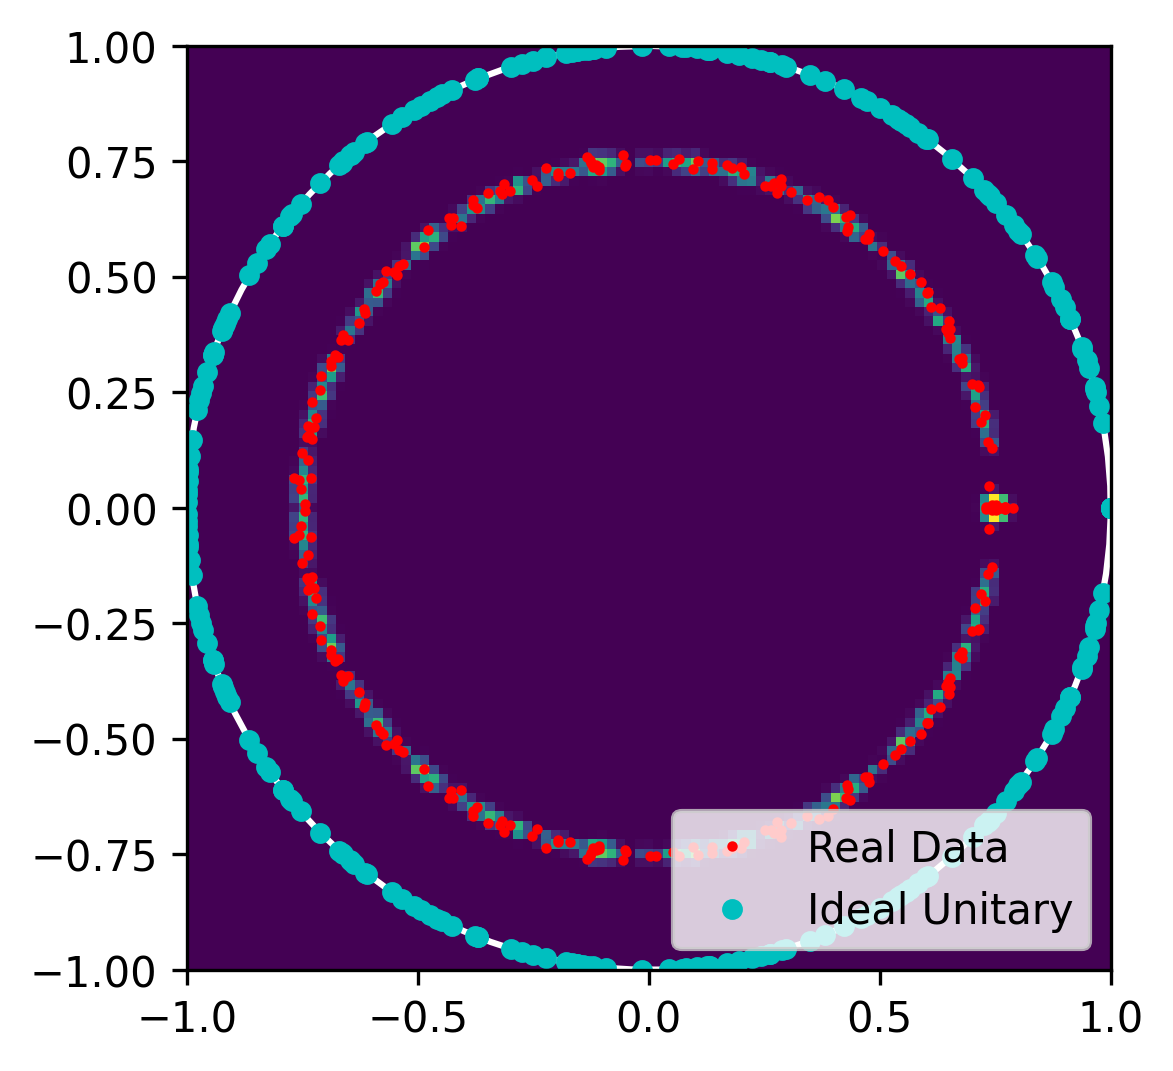

In [8]:
spectrum_model2 = channel_spectrum(model2.channel, use_coords=True)
spectrum_unitary2 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h, bins, _, _ = plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro", markersize=1.5)
plt.plot(spectrum_unitary2[:,0], spectrum_unitary2[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("integrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

In [19]:
model2 = loader(path + "nairobi_4qubit_integrable_medium.model")
d = model2.channel.d

np.random.seed(41)
random.seed(41)

circuit = nonintegrable_circuit(4, 2)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.75, kraus_part=KrausMap(d, rank=4))

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/nairobi_4qubit_nonintegrable_medium.model'

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample2 = resample_diluted(channel_diluted, U=U, num_samples = 100)

c:\Users\krisw\Documents\ModelNISQ\notebooks\nisq_spectrum\integrability\../../../src_tf\spectrum.py:95: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krisw\Documents\ModelNISQ\notebooks\nisq_spectrum\integrability\../../../src_tf\spectrum.py:95: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


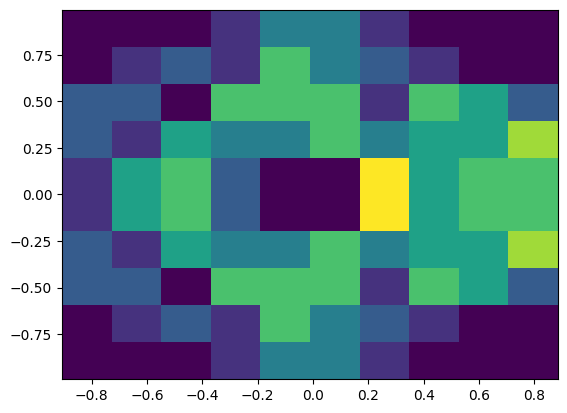

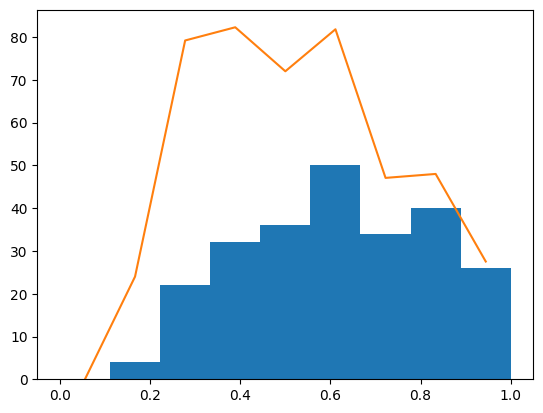

In [16]:
spectrum1 = channel_spectrum(model1.channel, use_coords=False, keep_real=False)
z_list1 = complex_spacing_ratio(spectrum1)

plt.hist2d(np.real(z_list1), np.imag(z_list1))
plt.show()
bins = np.linspace(0, 1, 10)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list1), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.show()

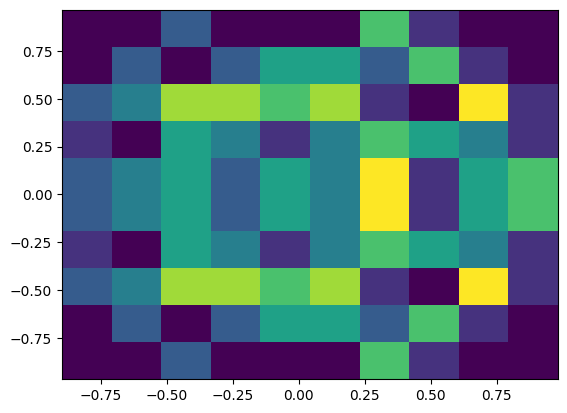

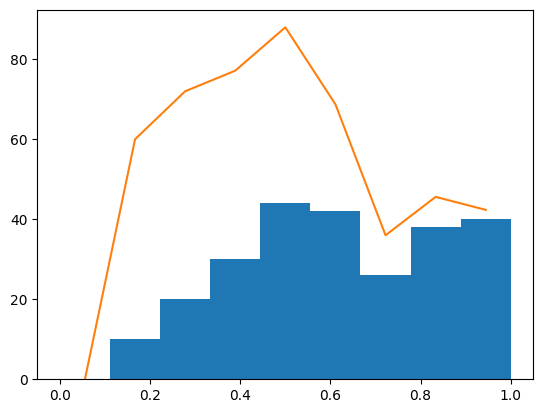

In [17]:
spectrum1 = channel_spectrum(model2.channel, use_coords=False, keep_real=False)
z_list1 = complex_spacing_ratio(spectrum1)

plt.hist2d(np.real(z_list1), np.imag(z_list1))
plt.show()
bins = np.linspace(0, 1, 10)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list1), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.show()

## Non-Integrable

In [ ]:
model2 = loader(data_path("manila_4qubit_nonintegrable_alternative.model"))
d = model2.channel.d

np.random.seed(42)
random.seed(42)

circuit = nonintegrable_circuit(4, 2)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.5, kraus_part=KrausMap(d, rank=10))

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample2 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_4104\1833139310.py:16: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000014402355570> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


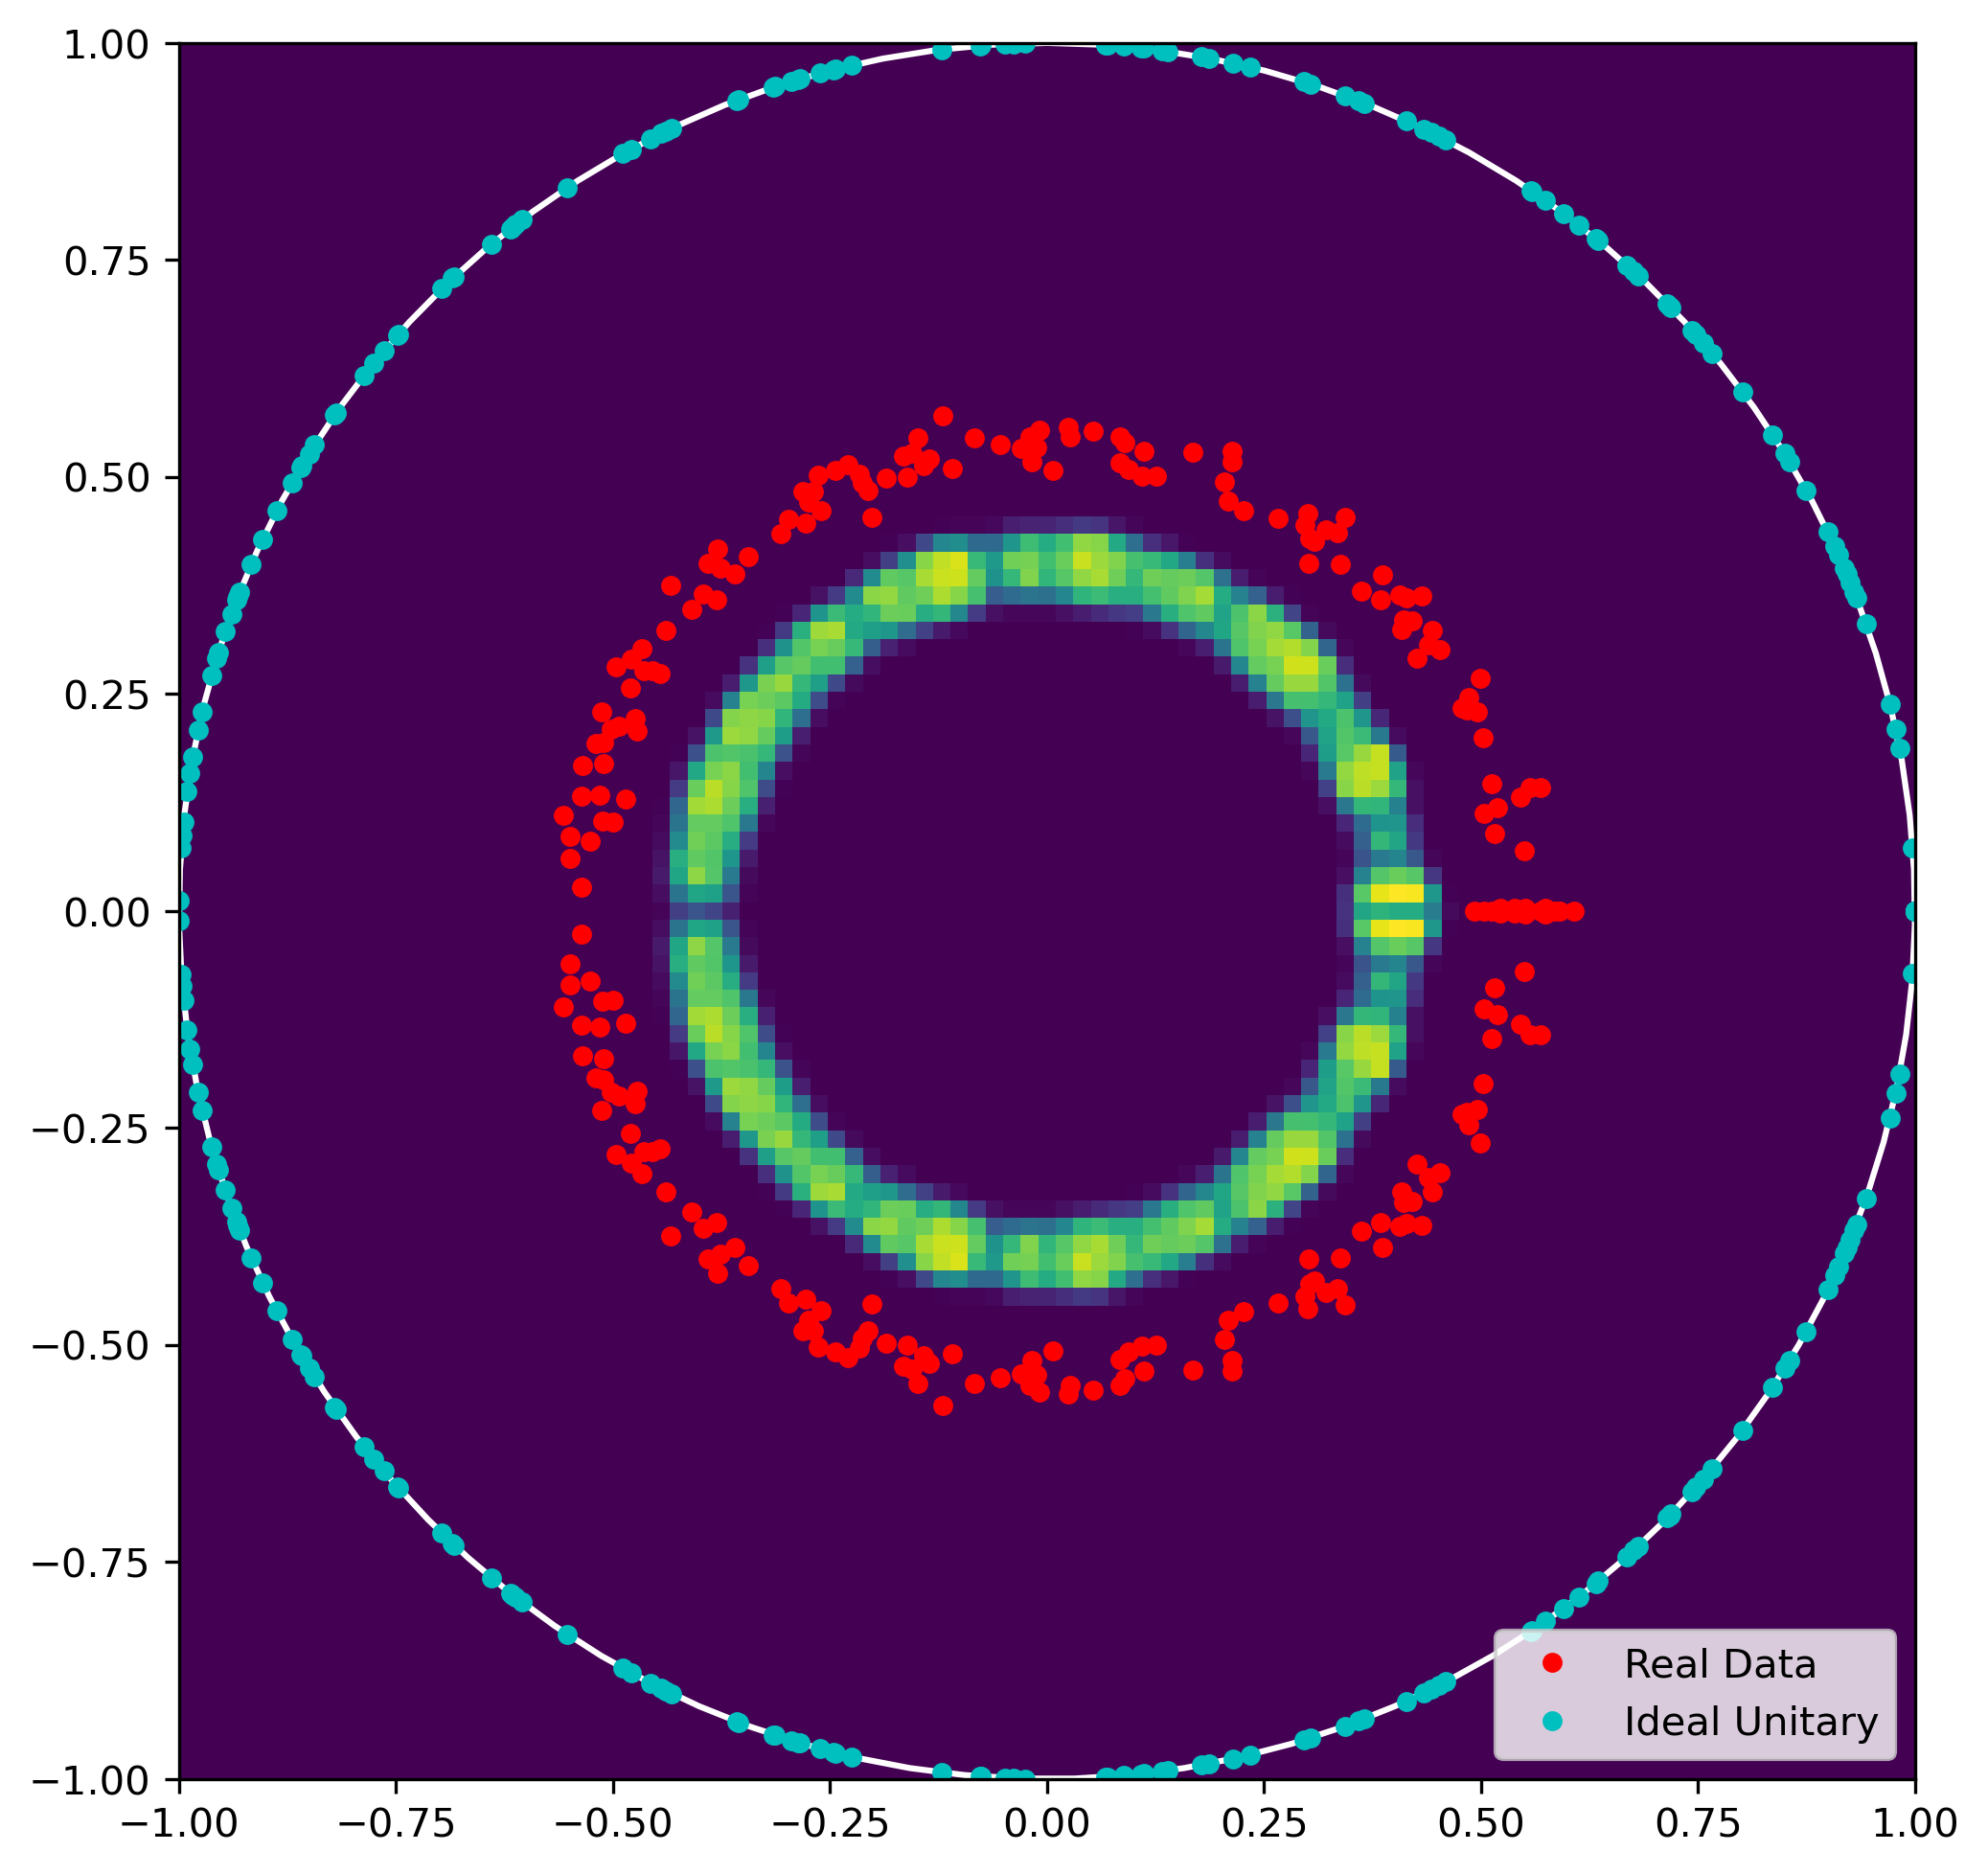

In [ ]:
spectrum_model2 = channel_spectrum(model2.channel, use_coords=True)
spectrum_unitary2 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h2, bins2, _, _ = plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro", markersize=4)
plt.plot(spectrum_unitary2[:,0], spectrum_unitary2[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

c:\Users\krist\Documents\ModelNISQ\notebooks\analysis\../../src_tf\spectrum.py:95: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krist\Documents\ModelNISQ\notebooks\analysis\../../src_tf\spectrum.py:95: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


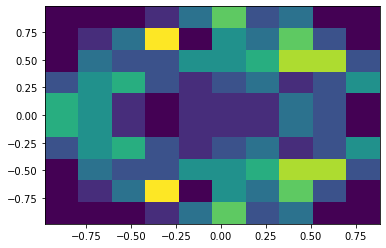

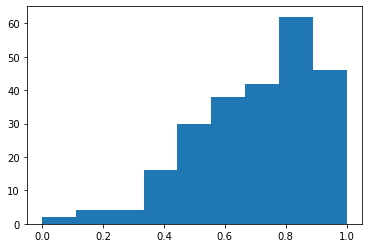

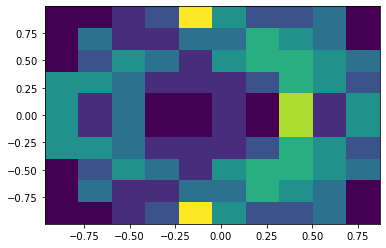

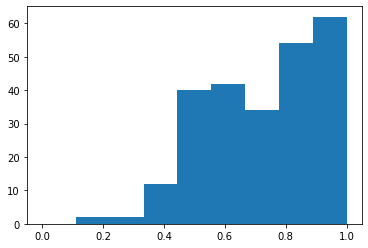

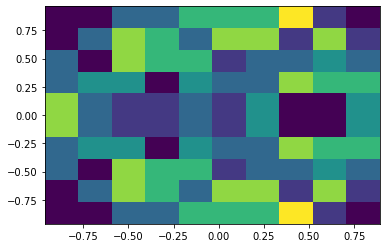

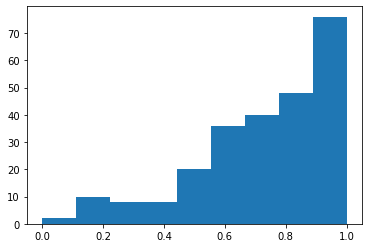

In [23]:
model3 = loader(data_path("belem_clifford_4qubit.model"))

spectrum1 = channel_spectrum(model1.channel, use_coords=False, keep_real=False)
z_list1 = complex_spacing_ratio(spectrum1)

plt.hist2d(np.real(z_list1), np.imag(z_list1))
plt.show()
plt.hist(np.abs(z_list1), bins = np.linspace(0,1,10))
plt.show()

spectrum2 = channel_spectrum(model2.channel, use_coords=False, keep_real=False)
z_list2 = complex_spacing_ratio(spectrum2)

plt.hist2d(np.real(z_list2), np.imag(z_list2))
plt.show()
plt.hist(np.abs(z_list2), bins = np.linspace(0,1,10))
plt.show()

spectrum3 = channel_spectrum(model3.channel, use_coords=False, keep_real=False)
z_list3 = complex_spacing_ratio(spectrum3)

plt.hist2d(np.real(z_list3), np.imag(z_list3))
plt.show()
plt.hist(np.abs(z_list3), bins = np.linspace(0,1,10))
plt.show()

In [4]:
model3 = loader(data_path("belem_clifford_4qubit.model"))
d = model3.channel.d

np.random.seed(42)
random.seed(42)

circuit = nonintegrabel_circuit(4, 4)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.4, kraus_part=KrausMap(d, rank=12))

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krisw\AppData\Local\Temp\ipykernel_11028\120863585.py:16: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x0000026D65061540> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


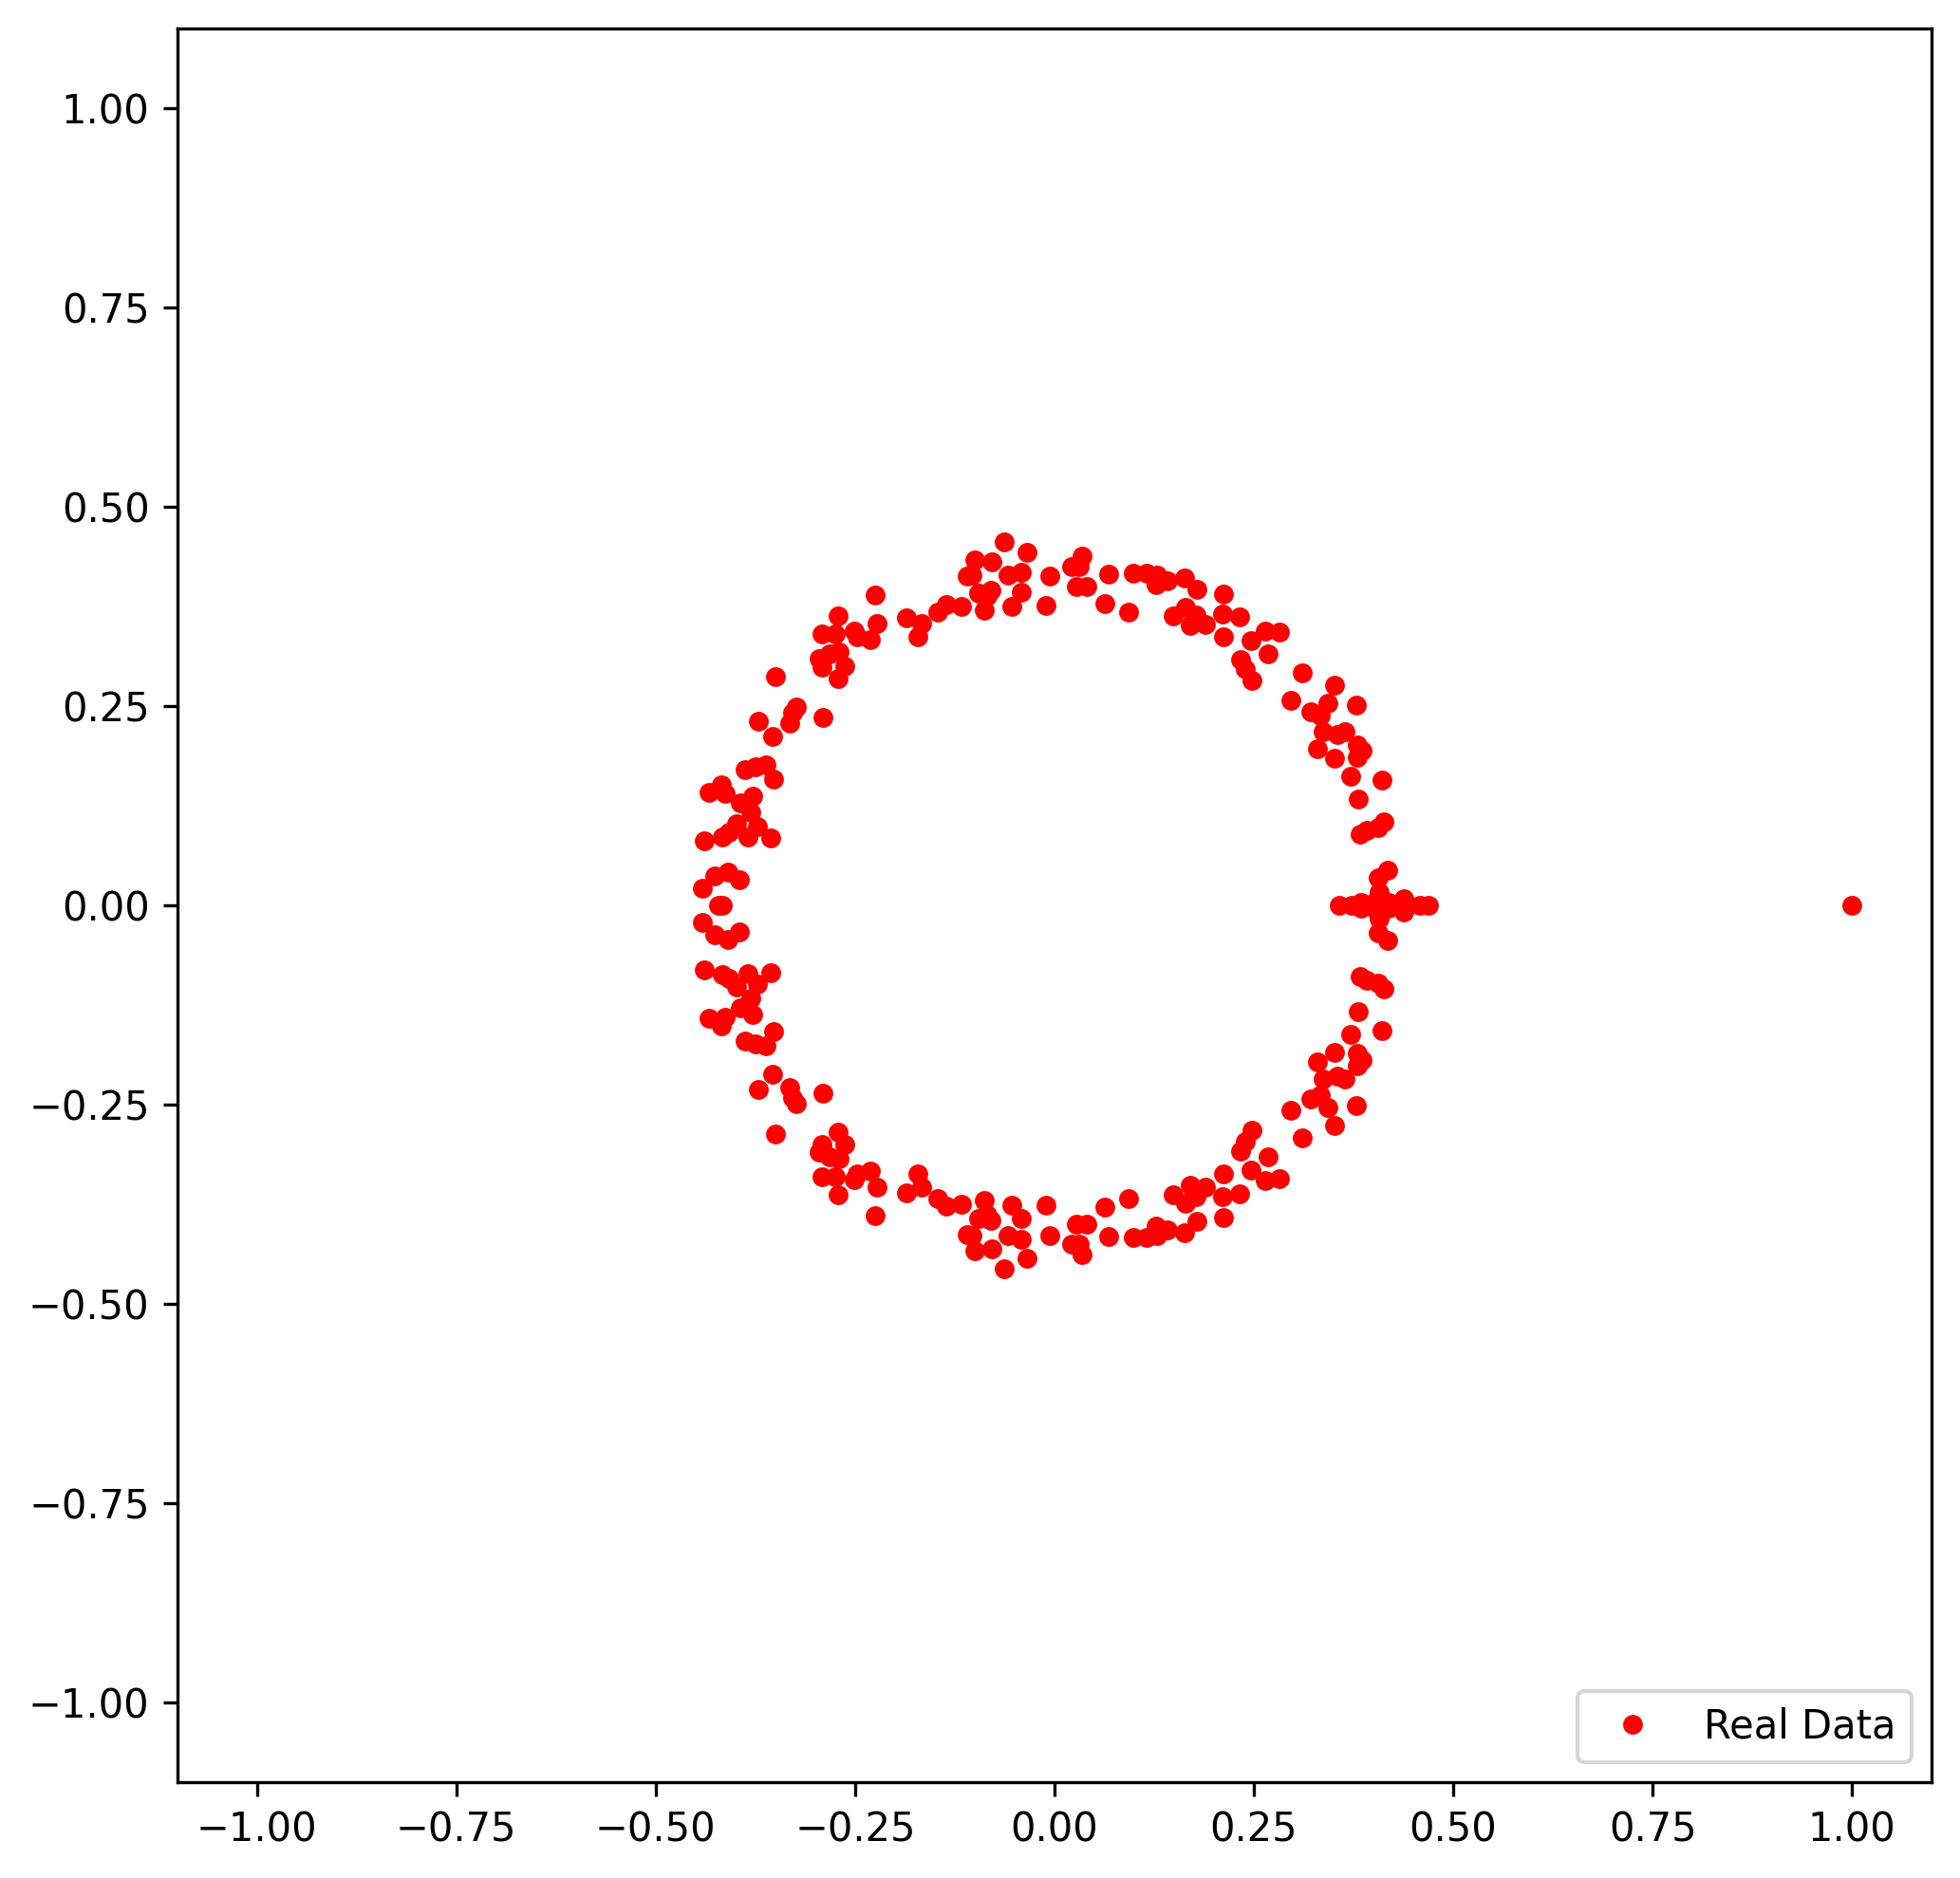

In [5]:
spectrum_model3 = channel_spectrum(model3.channel, use_coords=True)
#spectrum_unitary2 = channel_spectrum(channel_unitary, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

#plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")
plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "ro", markersize=4)
#plt.plot(spectrum_unitary2[:,0], spectrum_unitary2[:,1], "co", markersize=4)

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

In [21]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

n = 4
d = 2**n

circuit = nonintegrable_circuit(4, 4)
U = circuit_to_matrix(circuit)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.4, kraus_part=KrausMap(d, rank=32))

np.random.seed(42)
random.seed(42)



spectrum_resample1 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_2632\3960775590.py:11: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001A828388C10> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


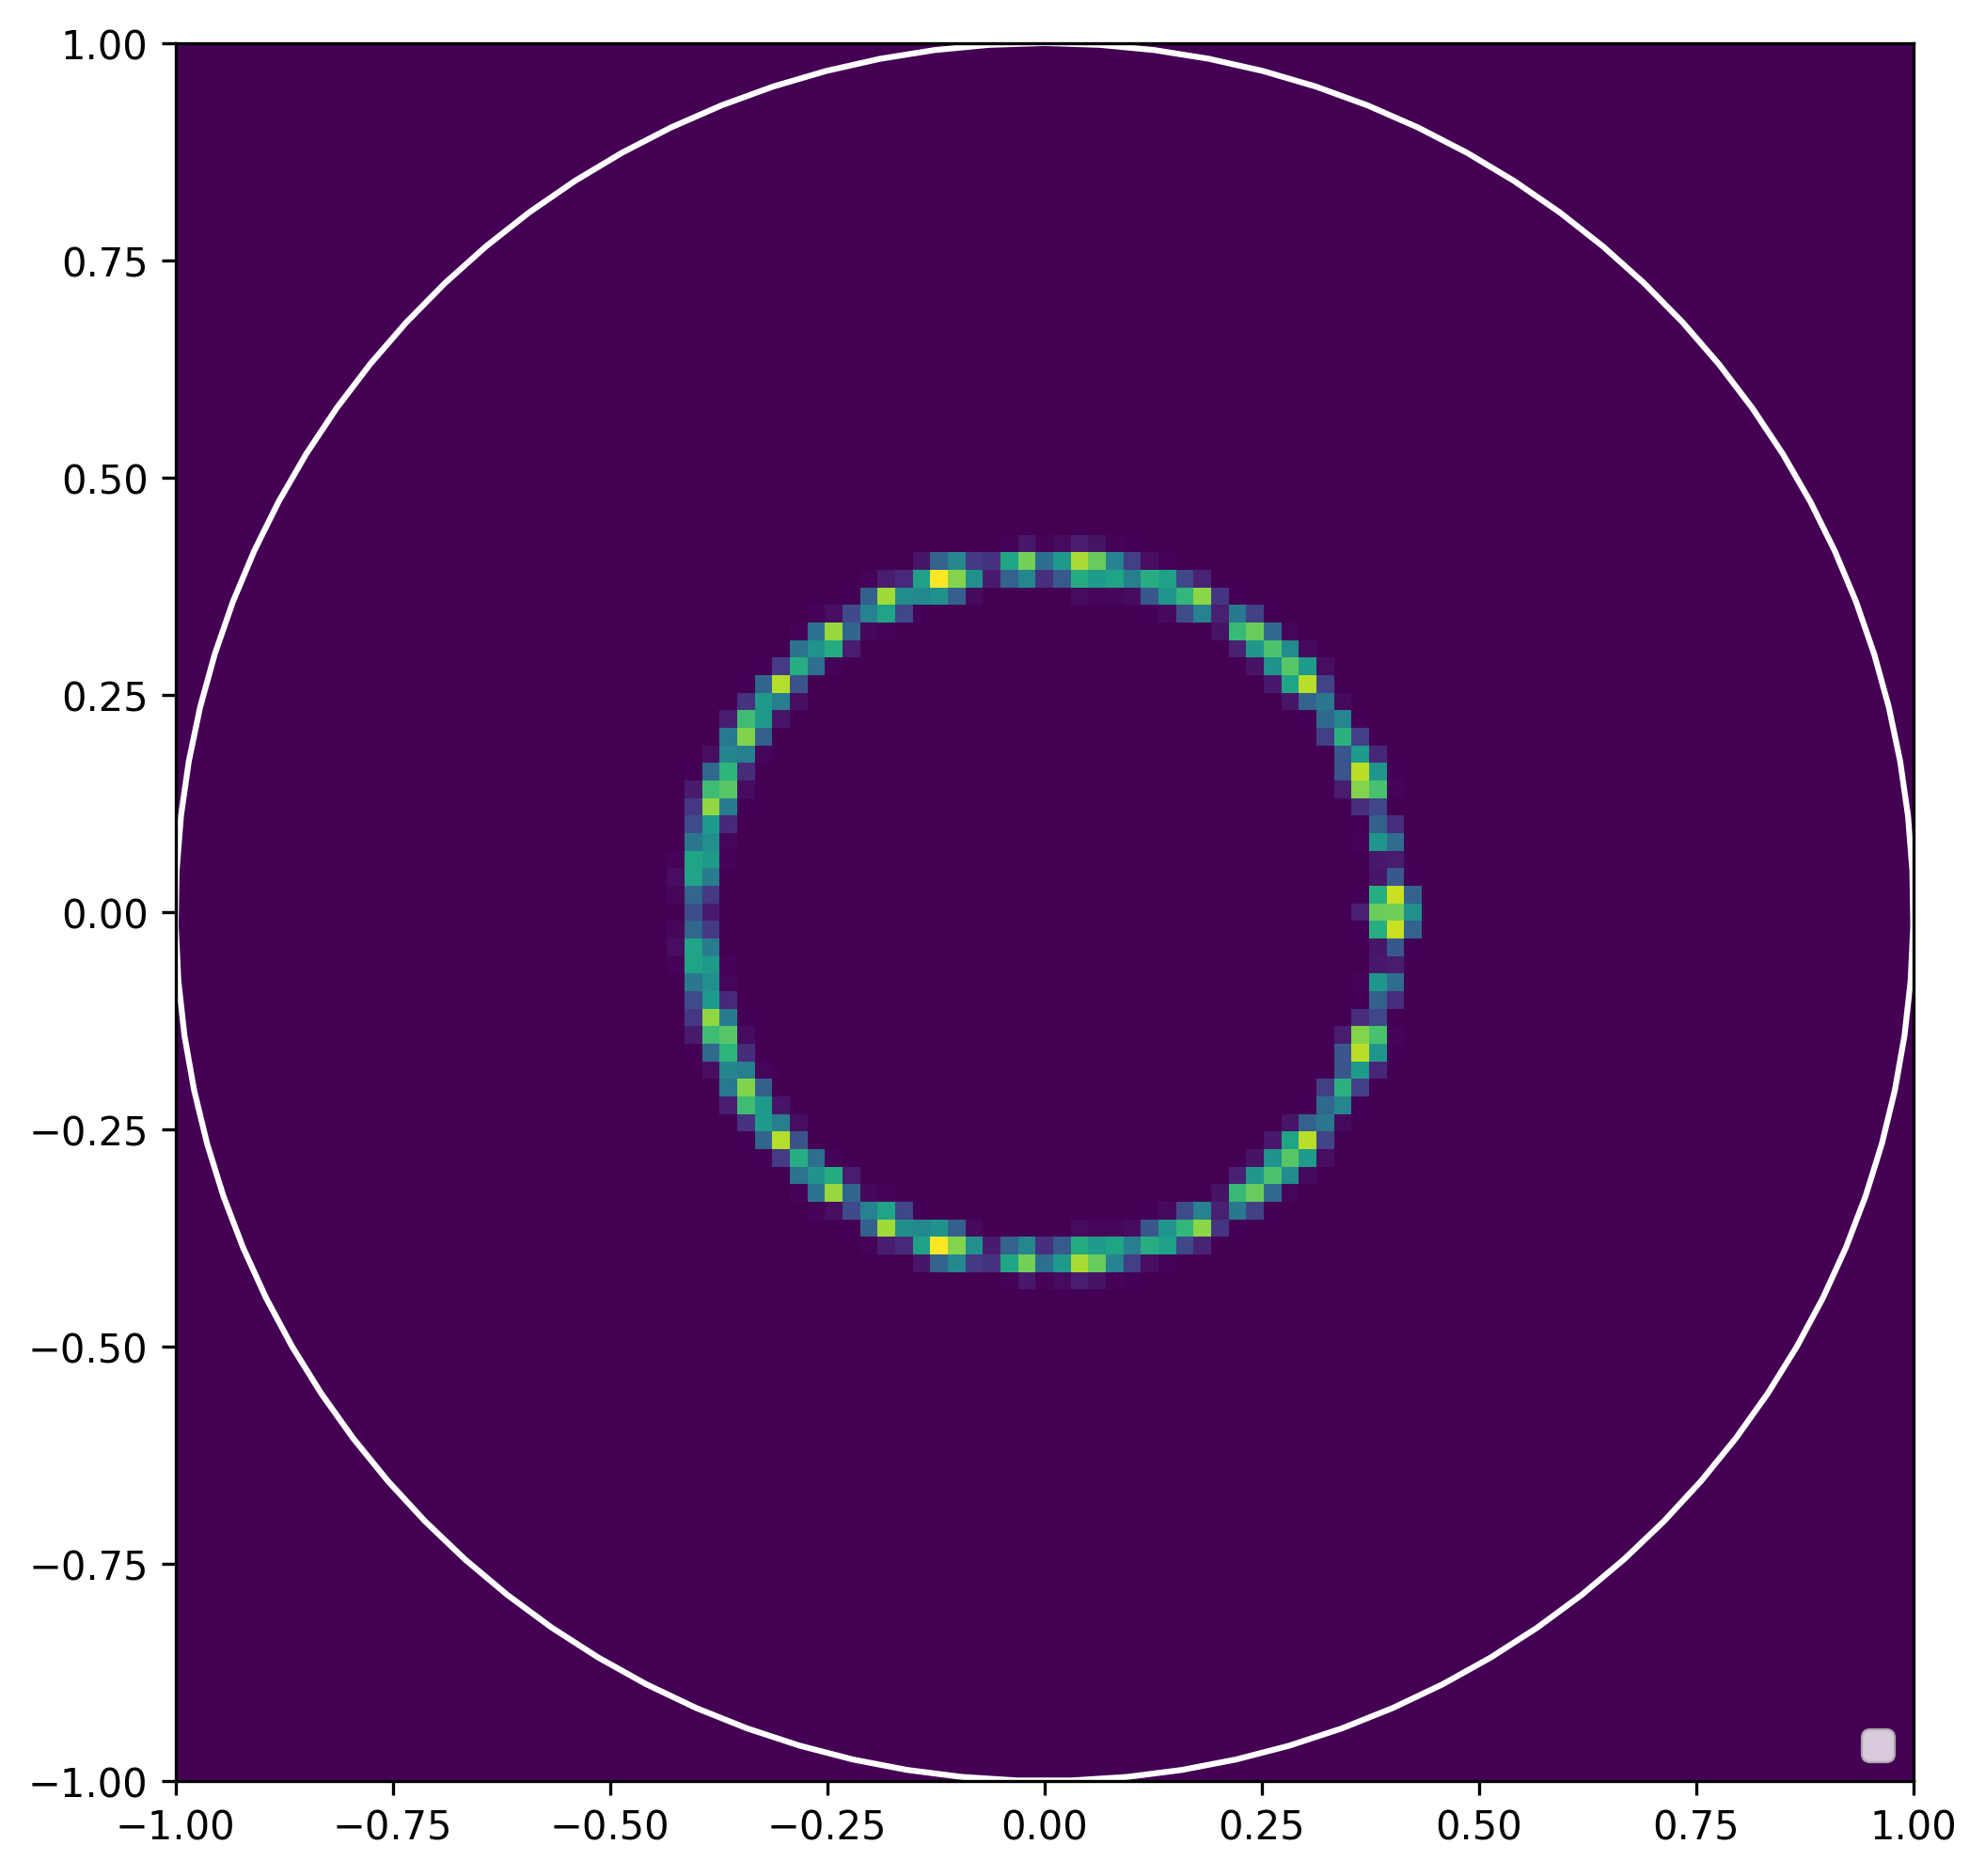

In [22]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h2, bins2, _, _ = plt.hist2d(spectrum_resample1[:,0], spectrum_resample1[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()

In [23]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

n = 4
d = 2**n
U = generate_unitary(d)

channel_unitary = ChoiMapStatic(U, mode="unitary")
channel_diluted = DilutedKrausMap(U=U, c=0.4, kraus_part=KrausMap(d, rank=32))

spectrum_resample2 = resample_diluted(channel_diluted, U=U, num_samples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krisw\AppData\Local\Temp\ipykernel_2632\2040689925.py:11: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001A828419330> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")


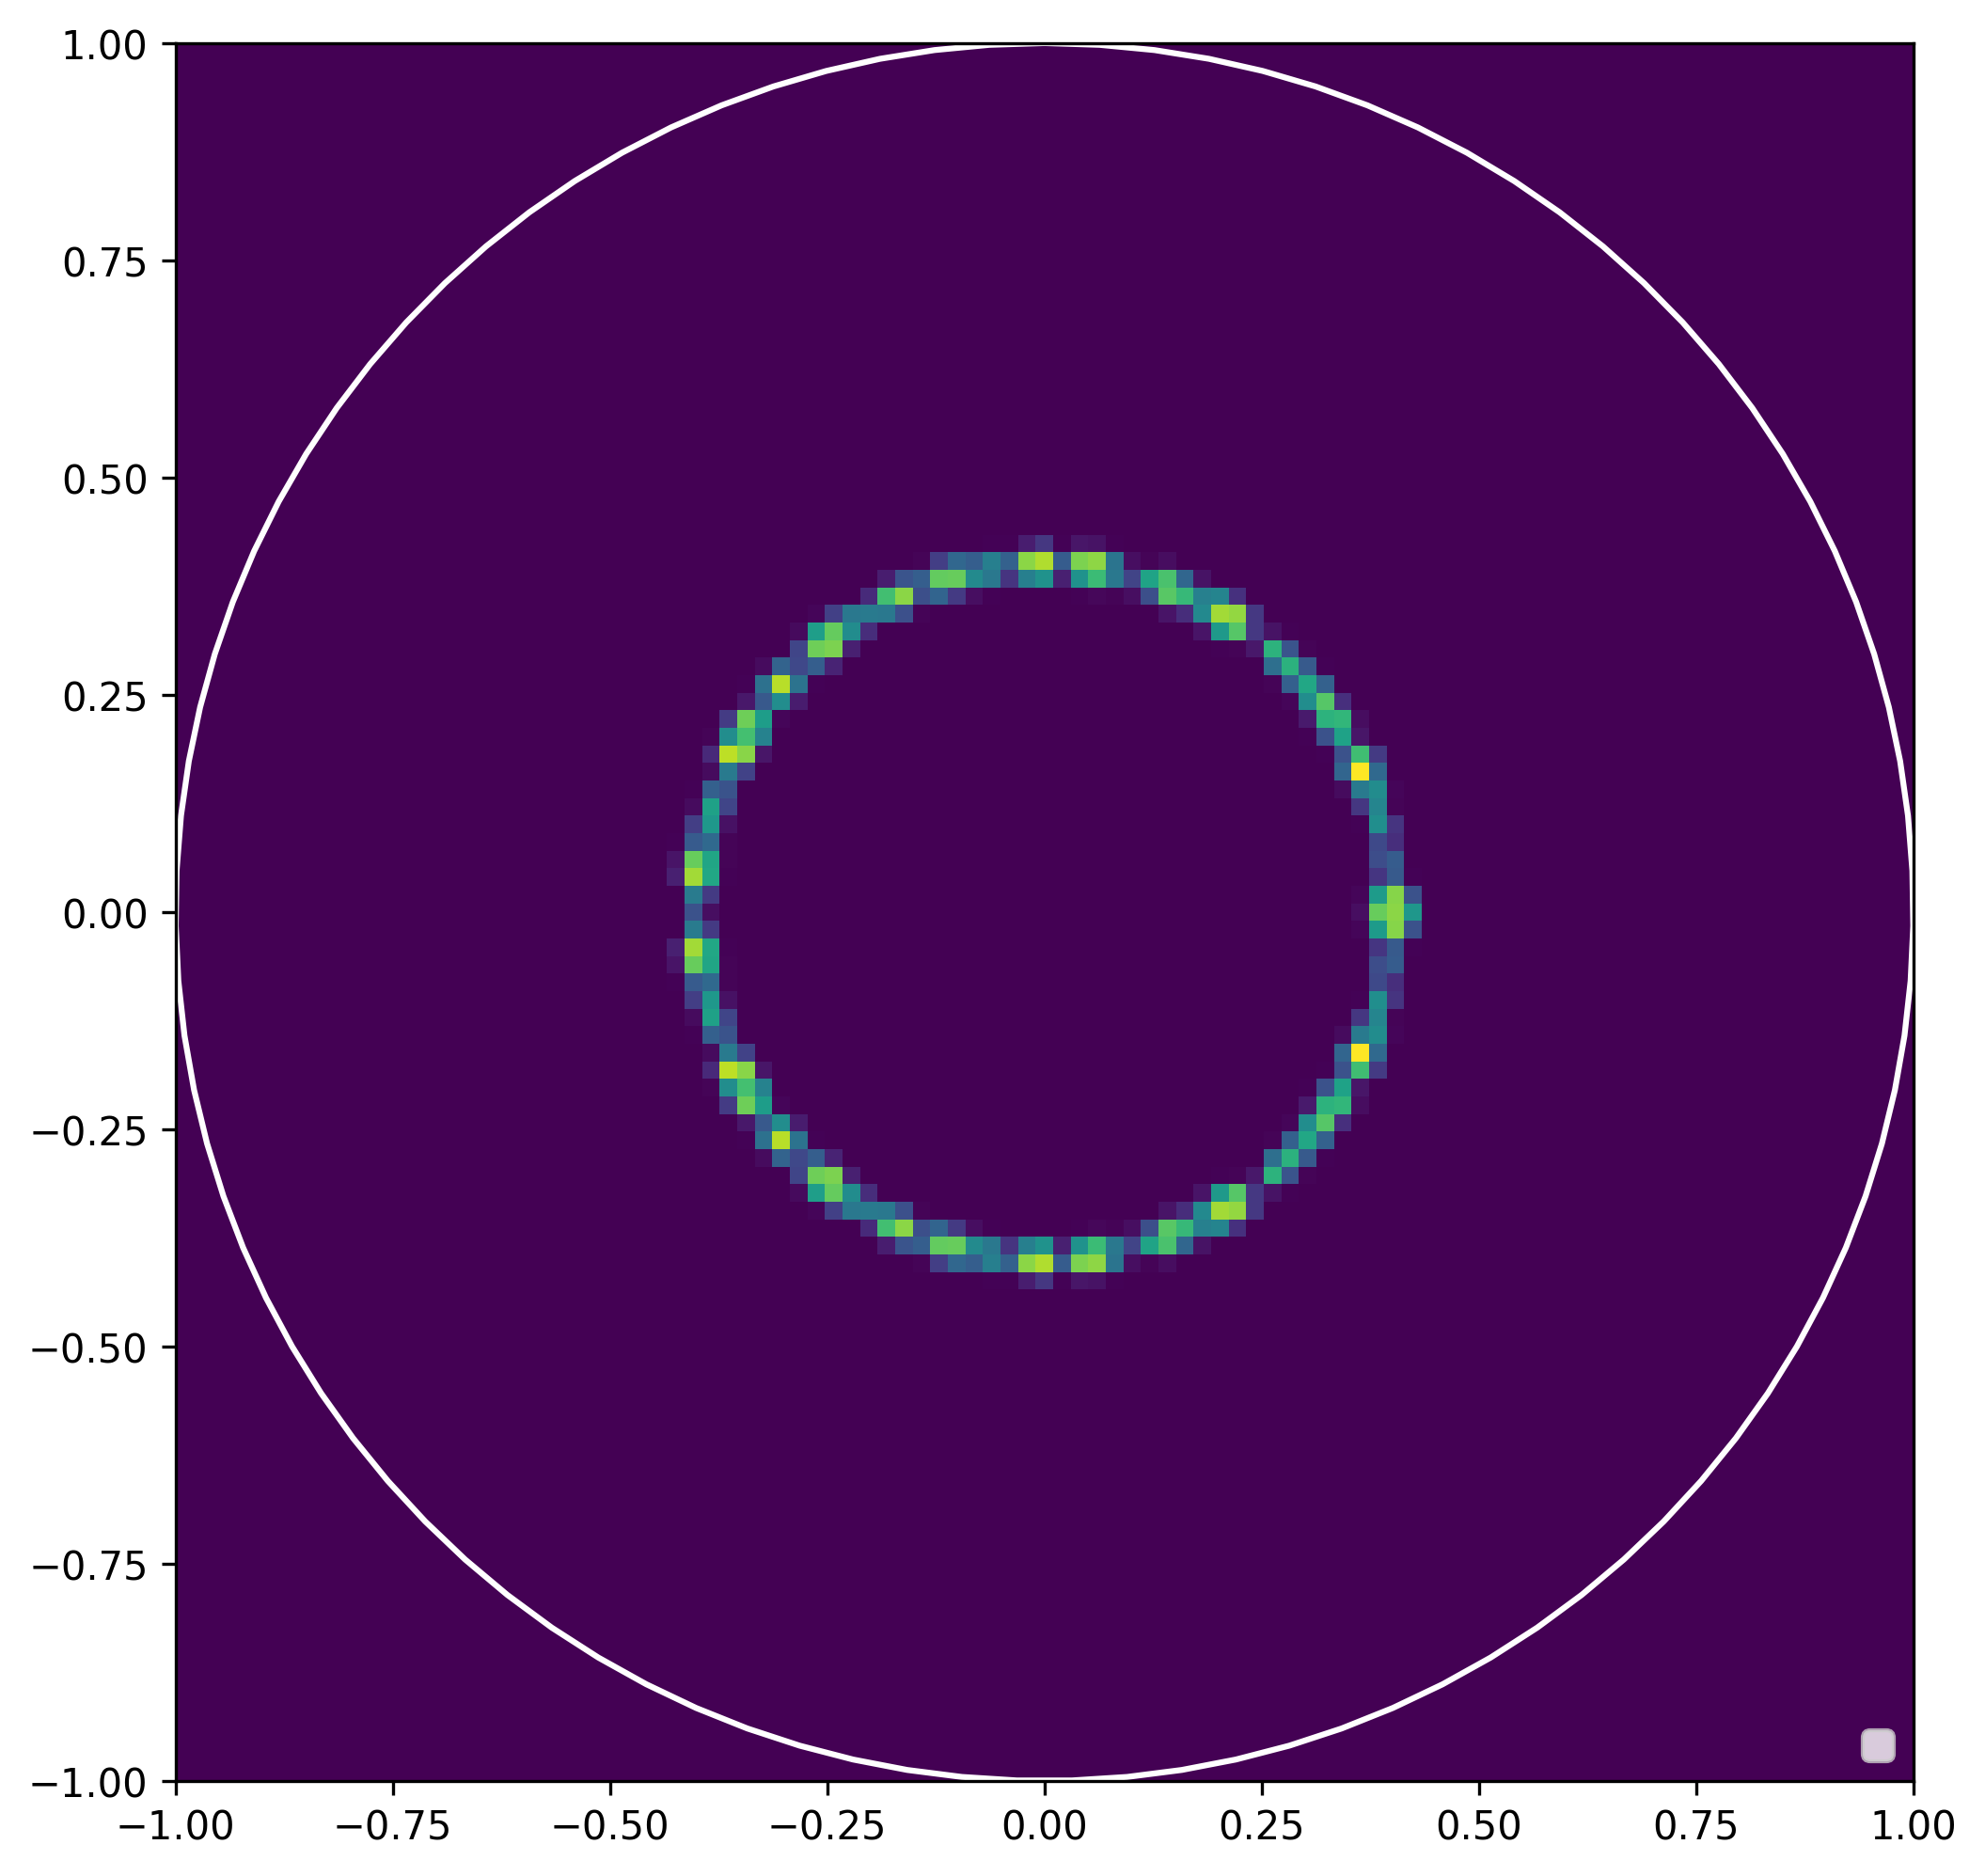

In [24]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

h2, bins2, _, _ = plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(*circle, "w")

plt.legend(["_", "Real Data", "Ideal Unitary"], loc="lower right")
#plt.savefig(image_path("nonintegrateble_circuit.pdf"), bbox_inches='tight')
plt.show()